In [ ]:
#if needed
#!conda install -c conda-forge xarray dask netCDF4 bottleneck

In [1]:
#This script can serve as template for downdloading copernicus data
#!motuclient --motu https://nrt.cmems-du.eu/motu-web/Motu --service-id MEDSEA_ANALYSISFORECAST_PHY_006_013-TDS --product-id cmems_mod_med_phy-ssh_anfc_4.2km_P1D-m --date-min "2022-10-12 00:00:00" --date-max "2023-10-12 01:00:00" --variable zos --variable zos_detided  --out-dir . --out-name ssh_med.nc --user famor1 --pwd yourpassword


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt

In [4]:
xr_ds = xr.open_dataset('model_data/ssh_med_12oct.nc')

In [5]:
xr_ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 380, lon: 1287)
Coordinates:
  * lon          (lon) float32 -17.29 -17.25 -17.21 -17.17 ... 36.21 36.25 36.29
  * time         (time) datetime64[ns] 2022-10-12T12:30:00 ... 2022-10-12T23:...
  * lat          (lat) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
Data variables:
    zos_detided  (time, lat, lon) float32 ...
    zos          (time, lat, lon) float32 ...
Attributes:
    title:                           Sea Surface Height (2D) - Hourly Mean - ...
    FROM_ORIGINAL_FILE__field_type:  hourly_mean_centered_at_time_field
    source:                          MFS EAS7
    institution:                     Centro Euro-Mediterraneo sui Cambiamenti...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    references:                      Clementi, E., Aydogdu, A., Goglio, A. C....
    comment:                         Please check in CMEMS catalogue the INFO...
    Conventions:                     CF-1.0
    bulletin_date:                   20230105
    bulletin_type:                   forecast
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [7]:
g=9.8; # gravity constant
R=6371000; # Earth radius
omega=2*np.pi/(24*60*60); # Earth rotation angle velocity

lons = xr_ds.lon.data
lats = xr_ds.lat.data

f = 2*omega*np.sin(np.deg2rad(lats))

ssh = xr_ds['zos'][0,:,:].data

u = np.zeros((len(lats),len(lons)))
v = np.zeros((len(lats), len(lons)))
for i in range(len(lons)):
    for j in range(len(lats)):
        if i>0 and i<len(lons)-1 and j>0 and j<len(lats)-1:
            #differentials of x,y space
            dx=(lons[i+1]-lons[i-1])*(R*np.cos(np.deg2rad(lats[j]))*np.pi/180)
            dy=(lats[j+1]-lats[j-1])*(R*np.pi/180)
            #velocity components from coriolis and preassure gradient
            #preassure computed as gravity(force) times ssh/dx gradient (area?)
            u[j,i]= -g/f[j]*(ssh[j+1,i] - ssh[j-1,i])/dy
            v[j,i]= g/f[j]*(ssh[j,i+1] - ssh[j,i-1])/dx

In [11]:


norm = np.sqrt(v**2+u**2)

geostrophy  = xr.Dataset(
    coords = dict(
        lon = lons,
        lat = lats,
    ),
    data_vars = dict(
        u = ( ['lat', 'lon'], u),
        v =  ( ['lat', 'lon'], v),
        norm = ( ['lat', 'lon'], norm)
    )
)

In [20]:
u_cliped = np.clip(u,-1,1)
v_cliped = np.clip(v,-1,1)
norm = np.sqrt(v_cliped**2+u_cliped**2)

geostrophy_clipped  = xr.Dataset(
    coords = dict(
        lon = lons,
        lat = lats,
    ),
    data_vars = dict(
        u = ( ['lat', 'lon'], u_cliped),
        v =  ( ['lat', 'lon'], v_cliped),
        norm = ( ['lat', 'lon'], norm)
    )
)

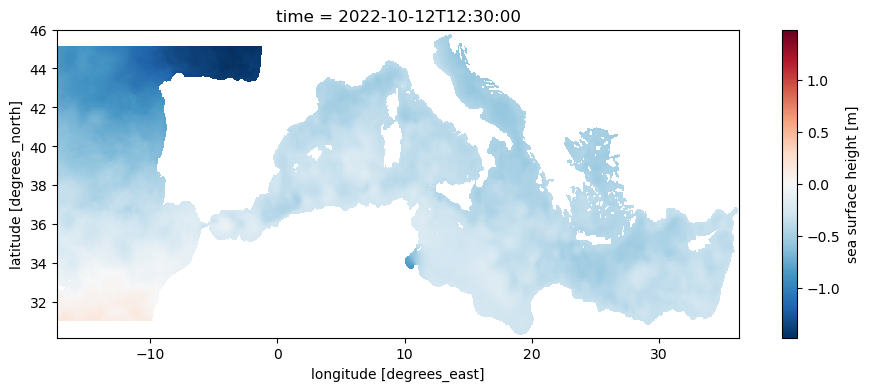

In [13]:
xr_ds['zos'][0,:,:].plot(figsize=(11,4))

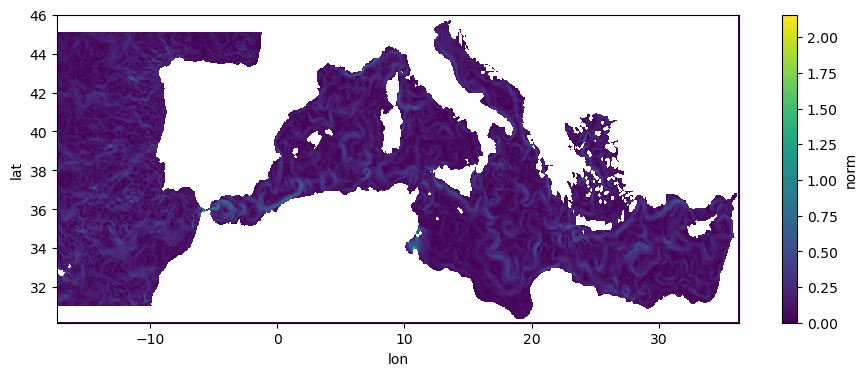

In [14]:
geostrophy.norm.plot(figsize=(11,4))

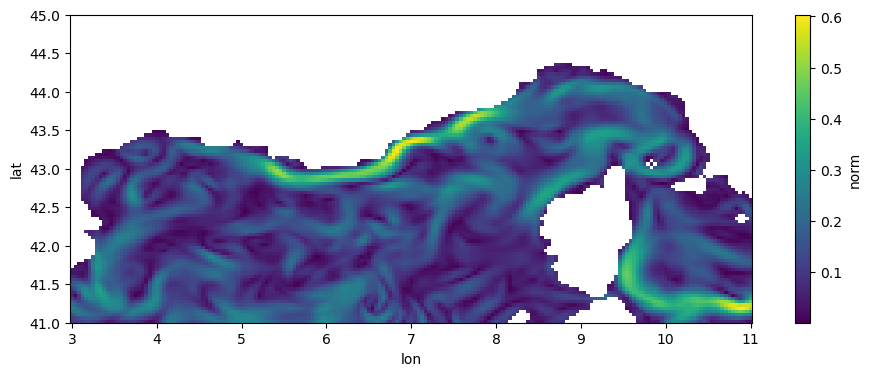

In [36]:
# Defining the boundaries
lon_bnds = [3, 11]
lat_bnds = [41, 45]

# Performing the reduction
geostrophy_clipped_sliced = geostrophy_clipped.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

geostrophy_clipped_sliced.norm.plot(figsize=(11,4))

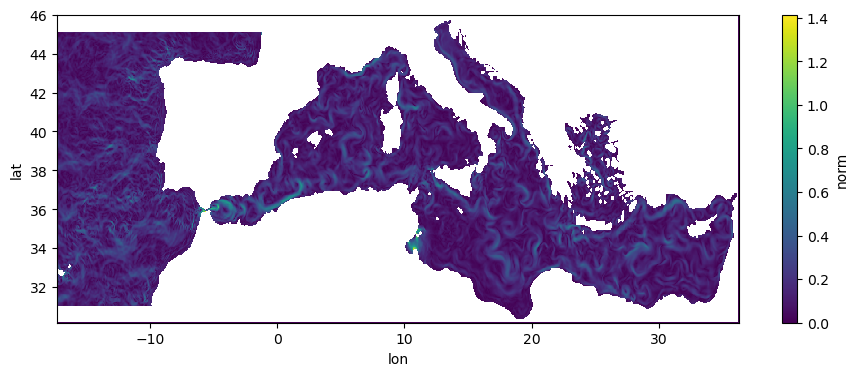

In [32]:
geostrophy_clipped.norm.plot(figsize=(11,4))

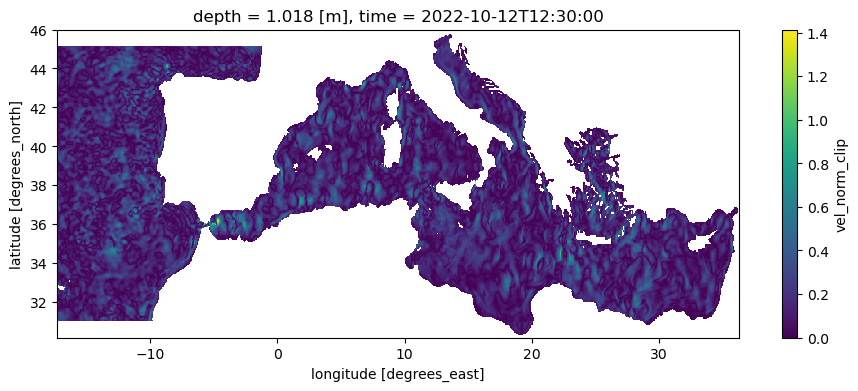

In [35]:
xr_ds_current = xr.open_dataset('model_data/current_med_12oct.nc')

vo = xr_ds_current.vo.data
uo = xr_ds_current.vo.data
vel_norm = np.sqrt(vo**2+uo**2)


u_cliped = np.clip(uo,-1,1)
v_cliped = np.clip(vo,-1,1)
vel_norm_clipped = np.sqrt(u_cliped**2+v_cliped**2)

xr_ds_current['vel_norm'] = (['time', 'depth', 'lat','lon'],  vel_norm)
xr_ds_current['u_clip'] = (['time', 'depth', 'lat','lon'],  u_cliped)
xr_ds_current['v_clip'] = (['time', 'depth', 'lat','lon'],  v_cliped)
xr_ds_current['vel_norm_clip'] = (['time', 'depth', 'lat','lon'],  vel_norm_clipped)
xr_ds_current.vel_norm_clip[0,:,:].plot(figsize=(11,4))